## Feature Extraction

In [4]:
from chevy.features import KingSafety, PawnStructure, BoardFeatures

class FeatureExtractor:
    def __init__(self, board):
        self.board = board
        self.king_features = [
            "king_mobility", "king_centrality", "king_attackers_looking_at_ring_1",
            "king_defenders_at_ring_1", "checked", "castling_rights"
        ]
        self.pawn_features = [
            "passed_pawns", "isolated_pawns", "blocked_pawns", "central_pawns"
        ]
        self.board_features = [
            "bishop_pair", "fianchetto_queen", "fianchetto_king", "queens_mobility",
            "open_files_rooks_count", "connected_rooks", "connectivity"
        ]

    def extract_features(self, color):
        """Extract all positional features for the current board state."""
        king_features = KingSafety(self.board, color=color)
        pawn_features = PawnStructure(self.board, color=color)
        board_features = BoardFeatures(self.board, color=color)

        feature_values = []
        for feature in self.king_features:
            value = getattr(king_features, feature)
            feature_values.append((feature, value))

        for feature in self.pawn_features:
            value = getattr(pawn_features, feature)
            feature_values.append((feature, value))

        for feature in self.board_features:
            value = getattr(board_features, feature)
            feature_values.append((feature, value))

        numerical_features = {}
        for feature, value in feature_values:
            if isinstance(value, int):
                numerical_features[feature] = value
            elif isinstance(value, list):
                array_sum = sum(value)
                numerical_features[feature] = array_sum

        return numerical_features


### Feature normalisation

In [2]:
import chess
import chess.engine
import pandas as pd
from tqdm import tqdm

engine = chess.engine.SimpleEngine.popen_uci("stockfish.exe") 

def evaluate_position(board):
    info = engine.analyse(board, chess.engine.Limit(time=0.05))
    return info["score"].relative.score(mate_score=10000) if "score" in info else None


def process_pgn_file(file_path):
    file = open(file_path)
    games = []
    while True:
        game = chess.pgn.read_game(file)
        if game is None:
            break
        games.append(game)
    print(f"Fetched {len(games)} games from {file_path}.")
    
    with tqdm(total=len(games), desc="Processing PGN File") as pbar:
        positions = []
        for game in games:
            board = game.board()
            feature_extractor = FeatureExtractor(board)
            for move in game.mainline_moves():
                board.push(move)
                features = feature_extractor.extract_features(chess.WHITE)
                positions.append(features)
            pbar.update(1)
    return positions

all_positions = []
for file_path in ["data/1.pgn", "data/2.pgn", "data/3.pgn"]:
    all_positions.extend(process_pgn_file(file_path))

df = pd.DataFrame(all_positions)
df.to_csv("data/chess_positions.csv", index=False)

engine.quit()

Fetched 6640 games from data/1.pgn.


Processing PGN File: 100%|██████████| 6640/6640 [05:43<00:00, 19.34it/s]


Fetched 6430 games from data/2.pgn.


Processing PGN File: 100%|██████████| 6430/6430 [05:44<00:00, 18.69it/s]


Fetched 8055 games from data/3.pgn.


Processing PGN File: 100%|██████████| 8055/8055 [07:08<00:00, 18.78it/s]


We obtain maximum value for each feature.

In [10]:
import pandas as pd
from tabulate import tabulate
from src.features.chevy import CHEVY_NORM_FACTOR

df = pd.read_csv("data/chess_positions.csv")
df_normalized = df / CHEVY_NORM_FACTOR

max_vals = []
for column in df.columns:
    max_value = df[column].max()
    max_vals.append((column, max_value))

print(tabulate(max_vals, headers=["Feature", "Max Value"], tablefmt="outline"))

+----------------------------------+-------------+
| Feature                          |   Max Value |
+==================================+=============+
| king_mobility                    |           8 |
| king_centrality                  |           3 |
| king_attackers_looking_at_ring_1 |           8 |
| king_defenders_at_ring_1         |           6 |
| checked                          |           1 |
| castling_rights                  |           1 |
| passed_pawns                     |           6 |
| isolated_pawns                   |           7 |
| blocked_pawns                    |           8 |
| central_pawns                    |           3 |
| bishop_pair                      |           1 |
| fianchetto_queen                 |           1 |
| fianchetto_king                  |           1 |
| queens_mobility                  |          80 |
| open_files_rooks_count           |           3 |
| connected_rooks                  |           1 |
| connectivity                 

Plotting the distribution of each features.

17


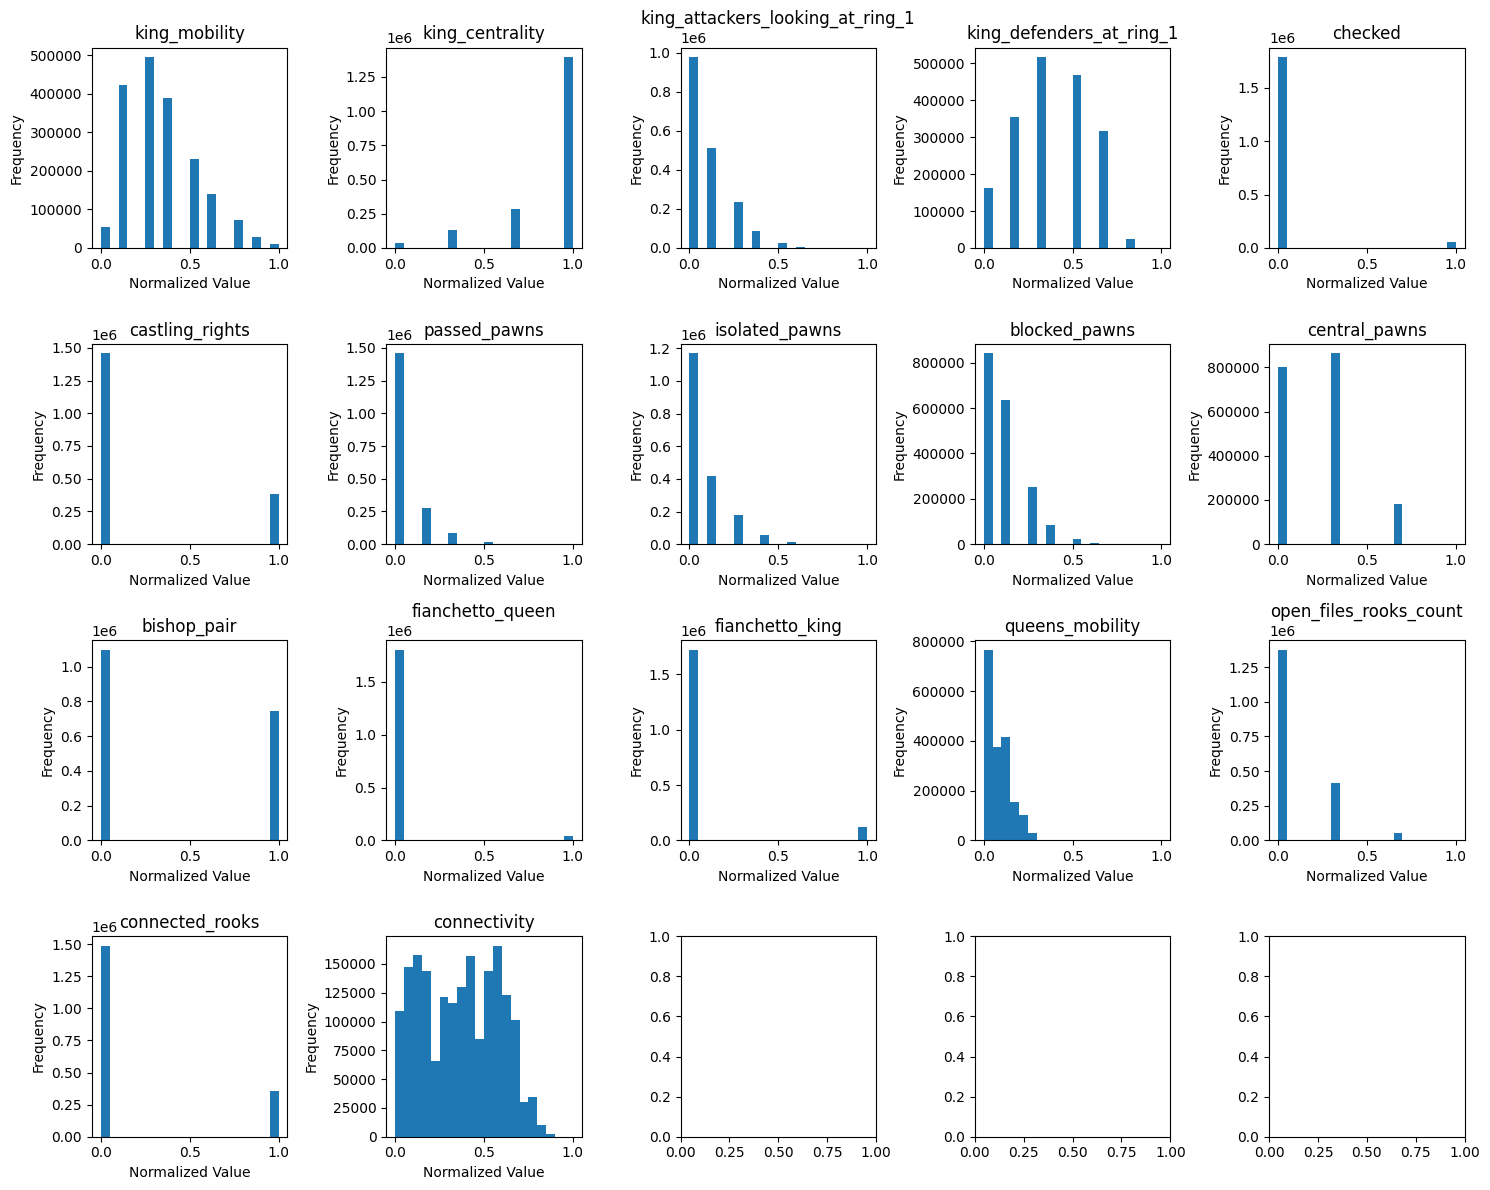

In [15]:
import matplotlib.pyplot as plt

num_bins = 20
num_rows = 4
num_cols = 5
columns = df_normalized.columns

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(columns): 
    ax = axes[i]
    ax.hist(df_normalized[column], bins=num_bins)
    ax.set_title(column)
    ax.set_xlabel('Normalized Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv('data/chess_positions.csv')

X = df.drop(columns=['evaluation_score'])
y = df['evaluation_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

feature_weights = pd.Series(model.coef_, index=X.columns)
print("Feature Weights:")
print(feature_weights)

normalized_weights = np.abs(feature_weights) / np.sum(np.abs(feature_weights))
print("Normalized Feature Weights:")
print(normalized_weights)